In [1]:
import pandas as pd
import numpy as np
import foxes
import foxes.variables as FV
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error
import customFunctions as fct
import matplotlib.pyplot as plt
import sklearn.neighbors

# Task 1

In [2]:
data_ERA5 = fct.read_ts_csv(f'reanalysis.csv')
data_LIDAR = fct.read_ts_csv(f'measurements/lidar.csv')

# Resample the data to 1h intervals
data_ERA5 = data_ERA5.resample('h', on='Time').mean()
data_LIDAR = data_LIDAR.resample('h', on='Time').mean()

# create a merged dataframe containing the ERA5 and the LIDAR data
data_mrgd = pd.merge(data_LIDAR, data_ERA5, how='right', on='Time')

# Ensure that the datetime format is used for the datetime index
data_mrgd.index = pd.to_datetime(data_mrgd.index)

data_mrgd['Mon']      = data_mrgd.index.strftime('%m')
data_mrgd['Hour']     = data_mrgd.index.strftime('%H')
data_mrgd.tail()
# data_mrgd.columns.values

,WS-99.2,WD-99.2,WS100,WD100,Mon,Hour
Time,,,,,,
2024-12-31 19:00:00,NaN,NaN,21.859,225.5,12,19
2024-12-31 20:00:00,NaN,NaN,21.991,226.8,12,20
2024-12-31 21:00:00,NaN,NaN,22.290,228.4,12,21
2024-12-31 22:00:00,NaN,NaN,21.714,228.1,12,22
2024-12-31 23:00:00,NaN,NaN,22.628,227.7,12,23


# Task 2

# Task 3

The long-term correction of the ERA05 model data using the LIDAR measurements.

In [3]:
param_grid = {
              "n_neighbors"       : [2,5,12,30],
              "leaf_size"         : [1, 2, 3,15,30],
              "p"                 : [1,2],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

classifier = sklearn.neighbors.KNeighborsRegressor()

WS_predictions, meas_idx = fct.correct_long_term_wind(data_mrgd[['WS100','WD100','Mon','Hour']], data_mrgd['WS-99.2'], 
                                                   classifier=classifier, param_grid=param_grid)
WD_predictions, meas_idx = fct.correct_long_term_wind(data_mrgd[['WS100','WD100','Mon','Hour']], data_mrgd['WD-99.2'], 
                                                   classifier=classifier, param_grid=param_grid)


Best score:
-1.38
Best parameters:
{'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Validation scores - Cross Validation:
-------------------------
R2-Score:  0.9342
MSE:  1.3357
RMSE:  1.1557
MAE:  0.8448
MAPE:  13.0987
Validation scores - Without Correction:
-------------------------
R2-Score:  0.9238
MSE:  1.5719
RMSE:  1.2537
MAE:  0.9267
MAPE:  13.6171
Validation scores - Model and Test Data:
-------------------------
R2-Score:  0.9401
MSE:  1.2785
RMSE:  1.1307
MAE:  0.8163
MAPE:  12.2684
Best score:
-1352.17
Best parameters:
{'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
Validation scores - Cross Validation:
-------------------------
R2-Score:  0.8463
MSE:  1356.6331
RMSE:  36.8325
MAE:  18.2059
MAPE:  38.8951
Validation scores - Without Correction:
-------------------------
R2-Score:  -4.0492
MSE:  44237.2186
RMSE:  210.3265
MAE:  188.498
MAPE:  92.4655
Validation scores - Model and Test Data:
--

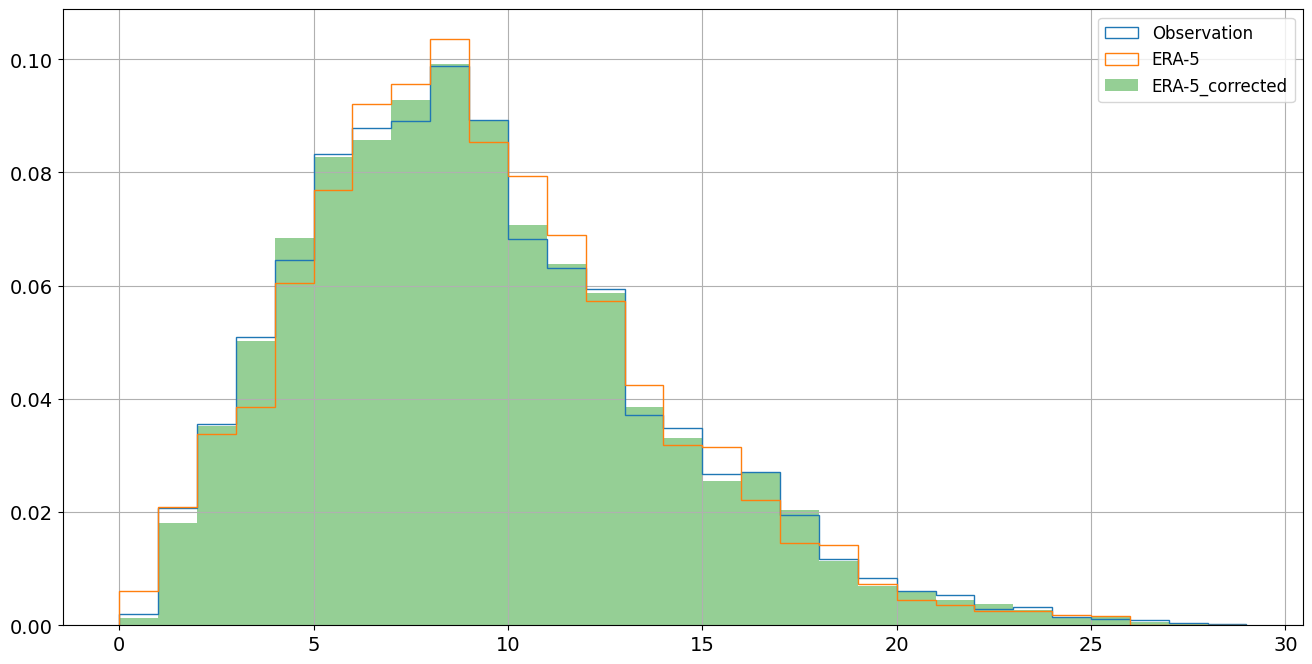

In [4]:
nbins = np.arange(0, 30, 1)

fig = plt.figure(figsize=(16,8))
plt.hist(data_mrgd['WS-99.2'].iloc[meas_idx], nbins, label='Observation', histtype='step', density=True)
plt.hist(data_mrgd['WS100'].iloc[meas_idx], nbins, label='ERA-5', histtype='step', density=True)
plt.hist(WS_predictions[meas_idx], nbins, label='ERA-5_corrected', alpha=0.5, density=True)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)
plt.grid()